# Automating Trading Operations

## Capital Management

### Kelly Criterion in Binomial Setting

In [1]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import plt, mpl

np.random.seed(1000)
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

/tmp/ipykernel_15850/3635527203.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
p = 0.55

f = p - (1 - p)

I = 50
n = 100

In [3]:
def run_simulation(f):
    c = np.zeros((n, I))
    c[0] = 100
    for i in range(I):
        for t in range(1, n):
            o = np.random.binomial(1, p)
            if o > 0:
                c[t, i] = (1 + f) * c[t - 1, i]
            else:
                c[t, i] = (1 - f) * c[t - 1, i]
    return c

In [4]:
c_1 = run_simulation(f)
c_1

array([[100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [ 90.        , 110.        ,  90.        , ..., 110.        ,
         90.        , 110.        ],
       [ 99.        , 121.        ,  99.        , ..., 121.        ,
         81.        , 121.        ],
       ...,
       [226.35134536, 338.12978752, 413.2697403 , ..., 123.97455355,
        123.97455355, 123.97455355],
       [248.9864799 , 371.94276627, 454.59671433, ..., 136.3720089 ,
        136.3720089 , 136.3720089 ],
       [273.88512789, 409.1370429 , 409.1370429 , ..., 122.73480801,
        150.00920979, 122.73480801]])

In [5]:
c_1.round(2)

array([[100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
       [ 90.  , 110.  ,  90.  , ..., 110.  ,  90.  , 110.  ],
       [ 99.  , 121.  ,  99.  , ..., 121.  ,  81.  , 121.  ],
       ...,
       [226.35, 338.13, 413.27, ..., 123.97, 123.97, 123.97],
       [248.99, 371.94, 454.6 , ..., 136.37, 136.37, 136.37],
       [273.89, 409.14, 409.14, ..., 122.73, 150.01, 122.73]])

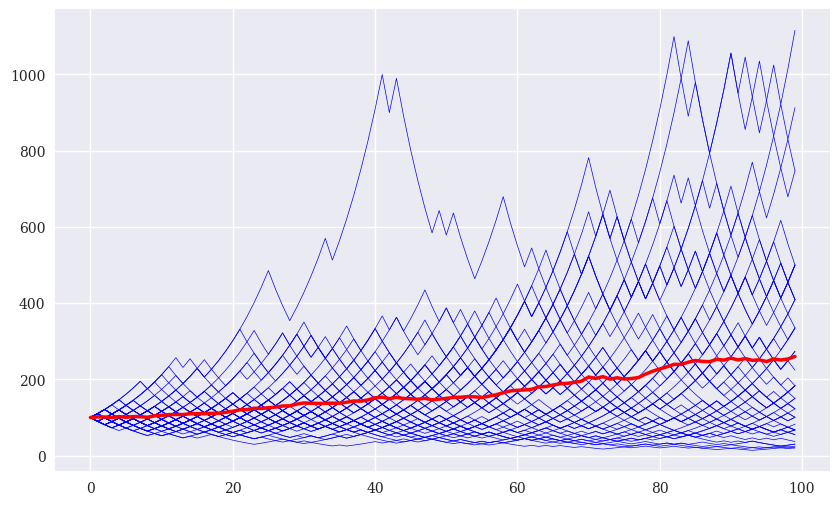

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(c_1, 'b', lw=0.5)
plt.plot(c_1.mean(axis=1), 'r', lw=2.5)

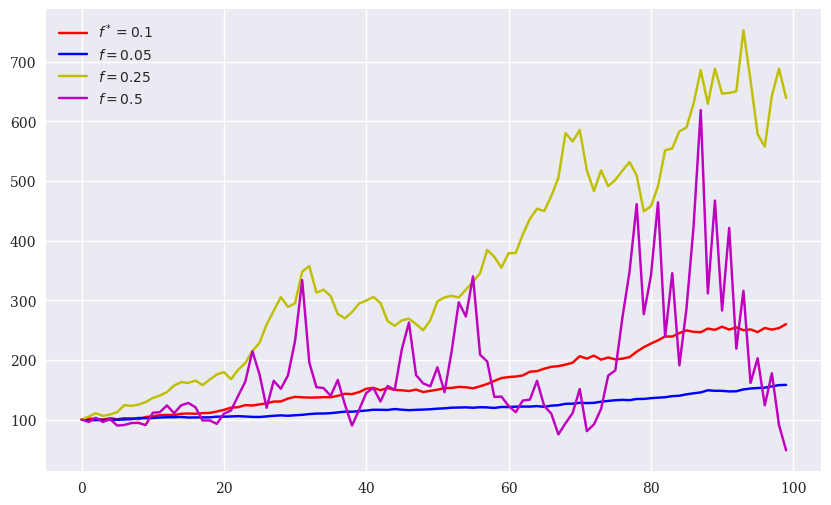

In [7]:
c_2 = run_simulation(0.05)
c_3 = run_simulation(0.25)
c_4 = run_simulation(0.5)

plt.figure(figsize=(10, 6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f=0.5$')
plt.legend(loc=0)

### Kelly Criterion for Stocks and Indices

In [13]:
raw = pd.read_csv('./pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True)
raw.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82


In [11]:
symbol = '.SPX'
data = pd.DataFrame(raw[symbol])
data.head()

,.SPX
Date,
2010-01-01,NaN
2010-01-04,1132.99
2010-01-05,1136.52
2010-01-06,1137.14
2010-01-07,1141.69


In [14]:
data['return'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data.tail()

,.SPX,return
Date,,
2019-12-23,3224.01,0.000866
2019-12-24,3223.38,-0.000195
2019-12-27,3240.02,0.000034
2019-12-30,3221.29,-0.005798
2019-12-31,3230.78,0.002942


In [15]:
mu = data['return'].mean() * 252
mu

0.09992181916534204

In [16]:
sigma = data['return'].std() * 252 ** 0.5
sigma

0.14761569775486583

In [18]:
r = 0.0

kelly = (mu - r) / sigma ** 2
kelly

4.585590244019806

In [19]:
equs = []

def kelly_strategy(f):
    global equs
    equ = 'equity_{:.2f}'.format(f)
    equs.append(equ)
    cap = 'capital_{:.2f}'.format(f)
    data[equ] = 1
    data[cap] = data[equ] * f
    for i, t in enumerate(data.index[1:]):
        t_1 = data.index[i]
        data.loc[t, cap] = data[cap].loc[t_1] * \
                            math.exp(data['return'].loc[t])
        data.loc[t, equ] = data[cap].loc[t] - \
                            data[cap].loc[t_1] + \
                            data[equ].loc[t_1]
        data.loc[t, cap] = data[equ].loc[t] * f

In [20]:
kelly_strategy(f * 0.5)

In [21]:
kelly_strategy(f * 0.66)

In [22]:
kelly_strategy(f)

In [26]:
data[equs].tail()

,equity_2.29,equity_3.03,equity_4.59
Date,,,
2019-12-23,6.628865,9.585294,14.205748
2019-12-24,6.625895,9.579626,14.193019
2019-12-27,6.626410,9.580610,14.195229
2019-12-30,6.538582,9.412991,13.818934
2019-12-31,6.582748,9.496919,14.005618


<Axes: xlabel='Date'>

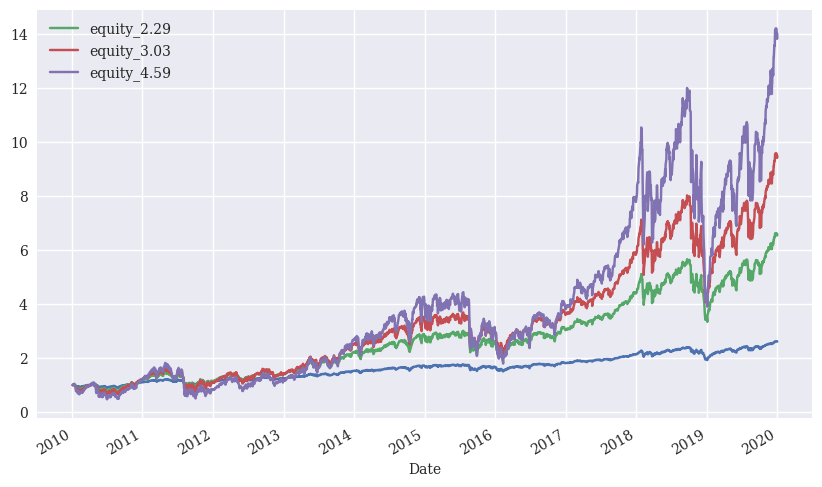

In [24]:
ax = data['return'].cumsum().apply(np.exp).plot(figsize=(10, 6))
data[equs].plot(ax=ax, legend=True)

## ML-Based Trading Strategy